In [2]:
# we need scipy version 1.1
# !pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 103kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [1]:
#performing necessary imports
import numpy as np
import os
import datetime # Conv2D+RNN
import os
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation , Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import scipy
from scipy.misc import imread, imresize
import warnings
warnings.filterwarnings("ignore")

In [2]:
#setting seeds , so that we can repeat the behaviours
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [4]:
# !unzip gdrive/MyDrive/UpgradNotes/Project_data.zip

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

In [5]:
#reading training and validation data
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size =32 #experiment with the batch size {32,64,128}

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(30)] # grabbing all the images for increased accuracy
    # img_idx=[0,1,2,4,6,7,8,10,11,12,14,15,16,18,16,20,22,24,25,26,28]
    # Conv2D + RNN -> select further lesser images  as it takes huge no of parameters.....REST ALL CODE REMAINS THE SAME
    # and takes large computational time and resources
    while True:
        t = np.random.permutation(folder_list)
        num_batches =  len(t) // batch_size # calculate the number of batches Note: Floor Division or typecast to INT
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # (y,z) = (120,120) / (84,84) / or any other of your choice # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    # resize
                    #resize image to 120x120
                    image = imresize(image,(120,120)).astype(np.float32)
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:, 0])/255 # normalise and feed in the image # mean of all the R channel
                    batch_data[folder,idx,:,:,1] = (image[:,:, 1])/255#normalise and feed in the image # mean of all the G channel
                    batch_data[folder,idx,:,:,2] = (image[:,:, 2])/255#normalise and feed in the image # mean of all the B channel
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
#         write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            rem_seq=len(t)%batch_size
            batch_created=len(t)//batch_size
            batch_data = np.zeros((rem_seq,len(img_idx),120,120,3)) # (y,z) = (120,120) / (84,84) / or any other of your choice # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_seq,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_seq): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch_created*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch_created*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # RESIZE CODE
                    image = imresize(image,(120,120)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:, 0])/255 # normalise and feed in the image # mean of all the R channel
                    batch_data[folder,idx,:,:,1] = (image[:,:, 1])/255#normalise and feed in the image # mean of all the G channel
                    batch_data[folder,idx,:,:,2] = (image[:,:, 2])/255#normalise and feed in the image # mean of all the B channel
                batch_labels[folder, int(t[folder + (batch_created*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield d    

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train' # Path of training images sub folder
val_path = 'Project_data/val' # Path of val images sub folder
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences) # 663
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences) # 100
num_epochs =35 # choose the number of epochs
print ('# epochs =', num_epochs) # 20, 30, 40, 50

# training sequences = 663
# validation sequences = 100
# epochs = 35


In [8]:
# modeling
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(30,120,120,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# since we have 5 classes to identify , hence 5 neurons with softmax acitivation
model.add(Dense(5,activation='softmax'))


# model = Sequential()
# model.add(Conv3D(32, (3, 3, 3), padding='same',input_shape=(16,120,120,3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv3D(32, (3, 3,3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2,2)))
# model.add(Dropout(0.5))

# model.add(Conv3D(64, (3, 3,3), padding='same'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv3D(64, (3, 3,3)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling3D(pool_size=(2, 2,2)))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(5))
# model.add(Activation('softmax'))

In [9]:
# using the SGD optimiser
optimizer=tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 32)    1

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'gdrive/MyDrive/UpgradNotes/Models/'+'Swarup' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss',verbose=1, factor=0.2, patience=2, min_lr=0.001)# write the REducelronplateau code here monitor='val_loss', patience, min_lr
callbacks_list = [checkpoint, LR]
# callbacks_list=[LR]

In [12]:
# if #images=55, batch_size=5, then we have 11 batches and 11 epochs
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
# if #images=58, batch_size=5, then we have 11 batches and 3 pending images, therefore 12 epoch will be reqd for last 3 images
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
steps_per_epoch

21

In [14]:
#Training the model 
history_sgd=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 32
Epoch 1/35
21/21 [==============================] - 119s 4s/step - loss: 1.9617 - categorical_accuracy: 0.2882 - val_loss: 81.6203 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 81.62026, saving model to gdrive/MyDrive/UpgradNotes/Models/Swarup_2021-04-1812_07_44.048476/model-00001-1.70471-0.33786-81.62026-0.23000.h5
Epoch 2/35
21/21 [==============================] - 85s 4s/step - loss: 1.3015 - categorical_accuracy: 0.4458 - val_loss: 32.1391 - val_categorical_accuracy: 0.1900

Epoch 00002: val_loss improved from 81.62026 to 32.13910, saving model to gdrive/MyDrive/UpgradNotes/Models/Swarup_2021-04-1812_07_44.048476/model-00002-1.20464-0.49774-32.13910-0.19000.h5
Epoch 3/35
21/21 [==============================] - 81s 4s/step - loss: 0.9788 - categorical_accuracy: 0.5770 - val_loss: 14.0023 - val_categorical_accuracy: 0.2800

Epoch 00003: val_loss improved from 32.13910 to 14.00228, saving model to gd

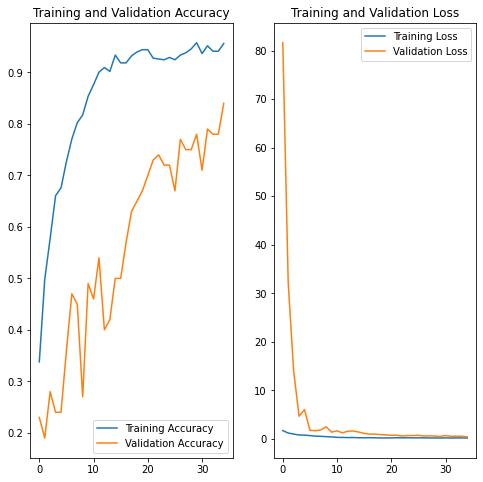

In [15]:
#plotting the metrics vs epoch
import matplotlib.pyplot as plt

acc = history_sgd.history['categorical_accuracy']
val_acc = history_sgd.history['val_categorical_accuracy']

loss = history_sgd.history['loss']
val_loss = history_sgd.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()